# Finding Strategic Location Using K-Means

## Section 1 - Introduction/Business Problem

### Introduction

**Indonesia**  is a country in Southeast Asia and Oceania, between the Indian and Pacific oceans. It consists of more than seventeen thousand islands, including Sumatra, Java, Sulawesi, and parts of Borneo (Kalimantan) and New Guinea (Papua). Indonesia is the world's largest island country and the 14th-largest country by land area, at 1,904,569 square kilometres (735,358 square miles).

Indonesia is centrally-located along ancient trading routes between the Far East, South Asia and the Middle East, resulting in many cultural practices being strongly influenced by a multitude of religions, including Buddhism, Christianity, Confucianism, Hinduism, and Islam, all strong in the major trading cities. This is why Indonesia is **rich in culture.**

**Indonesian cuisine** is one of the most diverse, vibrant, and colourful in the world, full of intense flavour. Many regional cuisines exist, often based upon indigenous culture and foreign influences such as Chinese, European, Middle Eastern, and Indian precedents. Rice is the leading staple food and is served with side dishes of meat and vegetables. Spices (notably chilli), coconut milk, fish and chicken are fundamental ingredients. Some popular dishes such as *nasi goreng*, *gado-gado*, *sate*, and *soto* are ubiquitous and considered as national dishes.

### Business Idea/Understanding

**Indonesian Restaurant** that serves all kinds of Indonesian food and beverages. The idea is to introduce Indonesian cultures to the world using Indonesian cuisine as the media. The first step in introducing Indonesian cultures is to gain some exposure from tourist visiting the country. In that case, locate a main tourist destination in Indonesia.

In [1]:
# Import Libraries
import numpy as np # Library to handle data in a vectorized manner
import pandas as pd # Library for data analysis
import json # Library to handle JSON files
import requests # Library to send HTTP requests using Python
import altair as alt
import datapane as dp

from geopy.geocoders import Nominatim # Convert an address into longitude and latitude values
from geopy.extra.rate_limiter import RateLimiter # To perform bulk operations while gracefully handling error responses and adding delays when needed
from pandas.io.json import json_normalize # Tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt # Visualization
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

from sklearn import metrics
from sklearn.cluster import KMeans # Clustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist

import folium # Map rendering

from bs4 import BeautifulSoup # Library to scrape information from web pages

print('Libraries imported!')

Libraries imported!


In [2]:
# Datapane Login Token
dp.login(token="insert login token here")

Connected successfully to https://datapane.com as jonando93


Information regarding visitors arrival to Indonesia by port of entry can be found on the internet.

In [ ]:
# Use pandas to scrape table from web page
visit_url = 'https://www.bps.go.id/indicator/16/1017/1/jumlah-kedatangan-wisatawan-mancanegara-ke-indonesia-menurut-pintu-masuk.html'

request1 = requests.get(visit_url)

visit_url_list = pd.read_html(request1.text)

visit_df = visit_url_list[2]
visit_df = visit_df.droplevel(0, axis=1)
visit_df.head()

Since the Dataframe is in Bahasa Indonesia, I am going to translate it to English.
<br>
The first row of the Dataframe is the **total visitors** that come to Indonesia. Since I need to know the amount of visitors by **each point of entry** and not by total visitors, I have to remove the first row.

In [ ]:
# Remove first row of visit_df dataframe
visit_df = visit_df.drop([0])

# Translate Dataframe
visit_df.columns = ['Airport (Name of Province)', '2019', '2018', '2017']
visit_df.reset_index(inplace=True)
visit_df.drop('index', axis=1, inplace=True)
visit_df['Airport (Name of Province)'] = ['Other Airports', 'Batam (Riau)', 'Kualanamu (North Sumatra)', 'Ngurah Rai (Bali)', 'Soekarno-Hatta (Jakarta)']
visit_df

In [ ]:
test = visit_df['2019'].to_list()
print(test)

As shown above, column '2019', '2018' and '2017' contain unicode character "u2009" and displayed as "space" character. I need to remove them in order for me to convert the column's datatype to *float*.

In [ ]:
def removeSpace(x):
    if isinstance(x, object):
        return x.replace(u"\u2009", "")
    else:
        return x

In [ ]:
visit_df['2019'] = visit_df['2019'].apply(removeSpace)
visit_df['2018'] = visit_df['2018'].apply(removeSpace)
visit_df['2017'] = visit_df['2017'].apply(removeSpace)
visit_df

In [ ]:
#Change column datatype from string to float
visit_df['2019'] = visit_df['2019'].astype(float)
visit_df['2018'] = visit_df['2018'].astype(float)
visit_df['2017'] = visit_df['2017'].astype(float)

In [ ]:
# Save report to html format
report = dp.Report(dp.DataTable(visit_df))
report.save(path='visit_df.html', open=True)

In [ ]:
# Publish visit_df
dp.Report(dp.DataTable(visit_df)).publish(name='visit_df', open=True)

In [ ]:
# Plot the Dataframe
label = ['Other Airports', 'Riau', 'NorthSumatra', 'Bali', 'Jakarta']
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax1 = ax.bar(visit_df['Airport (Name of Province)'], visit_df['2019'], tick_label=label)
ax2 = ax.bar(visit_df['Airport (Name of Province)'], visit_df['2018'], tick_label=label)
ax3 = ax.bar(visit_df['Airport (Name of Province)'], visit_df['2017'], tick_label=label)
plt.legend((ax1, ax2, ax3), ('2019', '2018', '2017'))
plt.title('Number of Foreign Tourist Arrivals to Indonesia by Entrance')
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)

In [ ]:
# Save to html
report = dp.Report(dp.Plot(fig))
report.save(path='visit_plot.html', open=True)

In [ ]:
# Publish plot
dp.Report(dp.Plot(fig)).publish(name='visit_plot', open=True)

Based on the data collected, as of 2019, the main destination for tourist in Indonesia is **Bali**.

> Bali is Indonesia's main tourist destination, with a significant rise in tourism since the 1980s. Tourism-related business makes up 80% of its economy.
>
> (https://en.wikipedia.org/wiki/Bali)

That concludes the first section.

## Section 2 - Data Preparation & Foursquare API

### Data Preparation

As concluded in section 1, the main destination for tourist in Indonesia is **Bali**. Continuing the discussion from *Business Idea*, in order for the business to thrive, it needs some exposure. The solution to that statement is to find the strategic location to build our restaurant in Bali, where there are alot of venues such as *Hotels*, *Villas*, other *restaurants*, etc..

In this section, my goal is to collect all the information regarding:<br>
1. How many cities are there in Bali province.
2. Each sub-district from every cities.
3. Coordinates (latitude, longitude) from each sub-district.
4. Venues categories in 500m radius from each sub-district coordinates. In order for me to get informaton regarding venues categories, I have to collect it from Foursquare using their API.

This data will have all the information needed that are required for the Explatory Data Analysis and Machine Learning - Clustering model.

**1. Collect information regarding cities and regencies in Bali province.**

The Bali province is divided into 8 regencies and 1 city. The only city is Denpasar.

In [ ]:
# List of Bali regencies and city
bali_url = 'https://en.wikipedia.org/wiki/Bali'

request2 = requests.get(bali_url)

bali_url_list = pd.read_html(request2.text)

bali_province_df = bali_url_list[2]

bali_province_df = bali_province_df[['Name', 'Capital']]
bali_province_df.drop(9, axis=0)

**2. Collect information regarding sub-districts in Bali province.**

Next, I am going to collect sub-district data from each city and regencies.

In [ ]:
# Create function to collect dataframe from webpage
def collectDataframe(url):
    request = requests.get(url)
    url_list = pd.read_html(request.text)
    url_df = url_list[0]
    url_df.drop(url_df.columns[[2, 4]], axis=1, inplace=True)
    return url_df

In [ ]:
# Create a list of webpage to collect dataframe
bali_df_list = ['https://kodeposresmi.com/kabupaten-kota/buleleng',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/2',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/3',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/4',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/5',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/6',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/7',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/8',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/9',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/10',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/11',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/12',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/13',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/14',
               'https://kodeposresmi.com/kabupaten-kota/buleleng/page/15',
               'https://kodeposresmi.com/kabupaten-kota/denpasar',
               'https://kodeposresmi.com/kabupaten-kota/denpasar/page/2',
               'https://kodeposresmi.com/kabupaten-kota/denpasar/page/3',
               'https://kodeposresmi.com/kabupaten-kota/denpasar/page/4',
               'https://kodeposresmi.com/kabupaten-kota/denpasar/page/5',
               'https://kodeposresmi.com/kabupaten-kota/badung',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/2',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/3',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/4',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/5',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/6',
               'https://kodeposresmi.com/kabupaten-kota/badung/page/7',
               'https://kodeposresmi.com/kabupaten-kota/bangli',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/2',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/3',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/4',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/5',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/6',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/7',
               'https://kodeposresmi.com/kabupaten-kota/bangli/page/8',
               'https://kodeposresmi.com/kabupaten-kota/gianyar',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/2',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/3',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/4',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/5',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/6',
               'https://kodeposresmi.com/kabupaten-kota/gianyar/page/7',
               'https://kodeposresmi.com/kabupaten-kota/jembrana',
               'https://kodeposresmi.com/kabupaten-kota/jembrana/page/2',
               'https://kodeposresmi.com/kabupaten-kota/jembrana/page/3',
               'https://kodeposresmi.com/kabupaten-kota/jembrana/page/4',
               'https://kodeposresmi.com/kabupaten-kota/jembrana/page/5',
               'https://kodeposresmi.com/kabupaten-kota/jembrana/page/6',
               'https://kodeposresmi.com/kabupaten-kota/karangasem',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/2',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/3',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/4',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/5',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/6',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/7',
               'https://kodeposresmi.com/kabupaten-kota/karangasem/page/8',
               'https://kodeposresmi.com/kabupaten-kota/klungkung',
               'https://kodeposresmi.com/kabupaten-kota/klungkung/page/2',
               'https://kodeposresmi.com/kabupaten-kota/klungkung/page/3',
               'https://kodeposresmi.com/kabupaten-kota/klungkung/page/4',
               'https://kodeposresmi.com/kabupaten-kota/klungkung/page/5',
               'https://kodeposresmi.com/kabupaten-kota/klungkung/page/6',
               'https://kodeposresmi.com/kabupaten-kota/tabanan',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/2',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/3',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/4',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/5',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/6',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/7',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/8',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/9',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/10',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/11',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/12',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/13',
               'https://kodeposresmi.com/kabupaten-kota/tabanan/page/14'
               ]

In [ ]:
# Create an empty Dataframe bali_df and append the iterated bali_df_list object
bali_df = pd.DataFrame()
for i in bali_df_list: 
    df_i = collectDataframe(i)
    bali_df = bali_df.append(df_i, ignore_index=True)

# Filter dataframe to only include word 'Bali' in 'Provinsi' (province) column
bali_df = bali_df[bali_df['Provinsi'].str.contains(r'(?:\s|^)Bali(?:\s|$)')]

# Check dataframe size - The correct size should be 687
print(bali_df.shape)
bali_df.head()

In [ ]:
bali_df.drop_duplicates(subset='Kelurahan',keep='first',inplace=True)
print(bali_df.shape)

Bali province has 687 sub-districts.

**3. Collecting coordinates from each sub-district in Bali province.**

The next step in this data preparation section is to collect *coordinates* from each sub-district in Bali. These coordinates will be used later in the **Foursquare API** to collect *venue categories*, and those categories will be used to build **Machine Learning - Clustering** model to help us in locating a strategic location to build the restaurant in Bali.

In [ ]:
# Rename column names
bali_df.columns = ['Province', 'Regency/City', 'Sub-District']

# Create new column called 'Geocoder' to improve the accuracy of the geocode
bali_df["Geocoder"] = bali_df["Sub-District"] + ", Bali, Indonesia"
bali_df.head()

In [ ]:
# Using Nominatim geocoder API
geolocator = Nominatim(user_agent='chris_p_bacon_') #crispy bacon! xD
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
bali_df['Location'] = bali_df['Geocoder'].apply(geocode) 

In [ ]:
# Check 'None' value
bali_df['Location'].isnull().sum()

There are 43 sub-districts that have 'None' value due to inconsistency in the spelling (e.g., Banyusri spelled as Banyuseri). Since it will take alot of time to replace the value one-by-one, I am going to remove it.

In [ ]:
# Remove 'None' value
bali_df = bali_df.loc[bali_df['Location'].isnull() == False]
bali_df.shape

In [ ]:
# Create 'Latitude' and 'Longitude' columns
bali_df['Latitude'] = bali_df['Location'].apply(lambda loc: loc.latitude)
bali_df['Longitude'] = bali_df['Location'].apply(lambda loc: loc.longitude)
bali_df.head()

In [ ]:
# Reset index
bali_df = bali_df.reset_index(drop=True)

Since I have collected the coordinates for each sub-district, **'Location'** column is no longer necessary.

In [ ]:
# Drop 'Location' columns
bali_df.drop(columns=['Location'])
bali_df.head()

These are the locations of each sub-district as seen on the map.

In [5]:
# Collect Bali's coordinate
coord_bali = 'Bali, Indonesia'
geolocator_bali = Nominatim(user_agent='chris_p_bacon_xD')
location_bali = geolocator_bali.geocode(coord_bali)
latitude_bali = location_bali.latitude
longitude_bali = location_bali.longitude
print('The geographical coordinate of Bali are {}, {}'.format(latitude_bali, longitude_bali))

# Create map of Bali
map_bali = folium.Map(location=[latitude_bali, longitude_bali], zoom_start=9.5)

# Add markers to the map
for lat, lng, dist in zip(bali_df['Latitude'], bali_df['Longitude'], bali_df['Geocoder']):
    label = '{}'.format(dist)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='blue',
                       fill=True,
                       fill_color='#FFD700',
                       fill_opacity=0.7,
                       parse_html=False).add_to(map_bali)

map_bali

The geographical coordinate of Bali are -8.3304977, 115.0906401


In [ ]:
# Save folium map to html
report = dp.Report(dp.Plot(map_bali))
report.save(path='folium_map_bali.html', open=True)

In [ ]:
# Publish the folium map
dp.Report(dp.Plot(map_bali)).publish(name='folium_map_bali')

**4. Collecting venues location in 500m radius from each sub-district.**

In this section, I am going to collect information about venues location from each sub-district. To gain information regarding those venues, I have to use Foursquare API.
<br><br>
**Foursquare** lets users search for restaurants, nightlife spots, shops and other places in a location. The app displays personalized recommendations based on factors that include the time of day, a user's check-in history, their "Tastes" and their venue ratings.
<br><br>
I am going to use Foursquare to collect nearby *venues information* from each sub-district's location using its coordinate (**latitude** and **longitude**).

In [ ]:
# Setup Foursquare credentials
CLIENT_ID = '3KHGUYZDYHRJXPMI4WUX5YY2Q0021DZUJ0GENJUZWAZ2CARH'
CLIENT_SECRET = '3RMCQMDYOM3RB5DDLMC2JCJ2DKW4KIFOZ0DPTMSMAE2ILOBQ'
VERSION = '20210101' # January 1st, 2021
LIMIT = 100 # default Foursquare API limit value

In [ ]:
# Create a function to repeat the process of collecting venues for each sub-district
def getNearbyVenues(names, latitudes, longitudes, radius=500): # set radius to 500 meters
    
    venues_list = [] #Create an empty list
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        #Create Foursquare API request URL
        fsq_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # Make the GET request
        results = requests.get(fsq_url).json()["response"]['groups'][0]['items']
        
        # Collect only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    # Save it into Dataframe    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Sub-District', 
                  'Sub-District Latitude', 
                  'Sub-District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Save the newly acquired information about venues in Bali into a new Dataframe.

In [ ]:
bali_venues = getNearbyVenues(names=bali_df['Sub-District'],
                             latitudes=bali_df['Latitude'],
                             longitudes=bali_df['Longitude'])

In [ ]:
# Check the shape of new ataframe
print(bali_venues.shape)
bali_venues.head()

In [ ]:
# Save to .csv
bali_venues.to_csv('bali_venues.csv', index=False)

Now let's see how many sub-districts that have venues in 500m radius around it.

In [ ]:
venues_bali = bali_venues['Sub-District'].unique()

There are 315 sub-districts that have 1 or more venues. Since the goal of this business idea is to find more exposure, that means we have to exclude those sub-districts that have no venues from the 'bali_df' dataframe.
<br><br>
The reason behind it is because I will use 'bali_df' dataframe to be merged with cluster labels resulted from machine learning clustering model in the next section (Section 3).

In [ ]:
bali_df = bali_df.loc[bali_df['Sub-District'].isin(venues_bali) == True]

In [ ]:
bali_df.shape

In [ ]:
# Save 'bali_df' to csv
bali_df.to_csv('bali_df.csv', index=False)

In [4]:
# To save time, read data locally
bali_df = pd.read_csv('bali_df.csv')

These are the data that will be used in the Exploratory Data Analysis and to build a Machine Learning - Clustering model to find the location to build the restaurant.

## Section 3 - Exploratory Data Analysis & Clustering Model

In this section, as discussed at the end of section 2, I will explore the dataset and build clustering model based on venues frequencies.
<br><br>
The goal of this project is to find the suitable location to build the restaurant. The business idea is to let visitors from other countries to try Indonesian cuisine. To achieve the business idea goal, I need to have more exposure so that people will recognize the restaurant. So that means, I have to find locations where there are alot of venues nearby.
<br><br>
So, in short:
<br>
More Venues = More People = More Exposure
<br>
**Goal = More Exposure** :D

### Exploratory Data Analysis

Let's explore the dataset by looking at how many venue categories are there per sub-district, as well as its unique categories.

To save time from going through Nominatim and Foursquare API, I have saved the dataframe in 'bali_venues' object locally, and I will import that DataFrame to do some exploratory data analysis.

In [6]:
# Read bali_venues.csv
bali_venue = pd.read_csv('bali_venues.csv')
bali_venue.head()

,Sub-District,Sub-District Latitude,Sub-District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Banjar,-8.205011,114.967194,Hot spring,-8.208671,114.967020,Pool
1,Banyuatis,-8.262936,115.031525,Dapur Hex,-8.264121,115.027539,Salad Place
2,Dencarik,-8.185746,114.982595,Cocoa Grounds,-8.185030,114.980930,Indonesian Restaurant
3,Gesing,-8.278434,115.054750,Banyan Tree,-8.281326,115.056206,Tree
4,Kaliasem,-8.170993,115.024820,villa nyoman,-8.170865,115.024815,Restaurant


In [7]:
# Groupby Sub-District
print(bali_venue.shape)
bali_venue.groupby('Sub-District').count().head()

(1612, 7)


,Sub-District Latitude,Sub-District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Sub-District,,,,,,
Ababi,2,2,2,2,2,2
Abang,1,1,1,1,1,1
Abian Tuwung,1,1,1,1,1,1
Abianbase,2,2,2,2,2,2
Akah,1,1,1,1,1,1


In [8]:
# Unique venue category
print('There are {} unique venue categories.'.format(len(bali_venue['Venue Category'].unique())))

There are 231 unique venue categories.


Let's do some data exploration. I need to see the **frequency of occurrences** of each venue category. To do that, I have to convert the category datatype from string to boolean (binary) using a method called **One Hot Encoding**. But its not that hot. xD

In [9]:
# One Hot Encoding
bali_onehot = pd.get_dummies(bali_venue[['Venue Category']], prefix='', prefix_sep='')

# Add 'Sub-District' column
bali_onehot['Sub-District'] = bali_venue['Sub-District']

# Move 'Sub-District' column to the first column
fixed_columns = [bali_onehot.columns[-1]] + list(bali_onehot.columns[:-1])
bali_onehot = bali_onehot[fixed_columns]

print(bali_onehot.shape)
bali_onehot.head()

(1612, 232)


,Sub-District,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfall,Wine Shop,Wings Joint,Yoga Studio
0,Banjar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Banyuatis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Dencarik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Gesing,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Kaliasem,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Out of 232 columns, there are multiple columns that categorized as different venues even though its actually the same. (e.g. Cafetaria & Cafe). So I have to generalize the venue categories before we go further into the EDA. For example, rename all Cafetaria to Cafe.

In [ ]:
# Column Generalization
## Transpose Dataframe
df_trans = bali_onehot.T
df_trans.columns = df_trans.iloc[0]
df_trans.index.name = None
df_trans.columns.name = None
df_trans.drop(df_trans.index[0], inplace=True)
df_trans.reset_index(inplace=True)
df_trans.rename(columns={'index' : 'Sub-District'}, inplace=True)

## Generalize Dataframe
df_trans.loc[df_trans['Sub-District'].str.contains('Restaurant'), ['Sub-District']] = 'Restaurant'
df_trans.loc[df_trans['Sub-District'].str.contains('Caf'), ['Sub-District']] = 'Cafe'
df_trans.loc[df_trans['Sub-District'].str.contains('Hotel'), ['Sub-District']] = 'Hotel'
df_trans.loc[df_trans['Sub-District'].str.contains('Garden'), ['Sub-District']] = 'Garden'
df_trans.loc[(df_trans['Sub-District'].str.contains('Shop')) & (df_trans['Sub-District'] != 'Shopping Mall'), ['Sub-District']] = 'Shop'
df_trans.loc[df_trans['Sub-District'].str.contains('Art'), ['Sub-District']] = 'Art Gallery'

# Groupby to 'combine' all venue categories that has same value after generalization
df_trans = df_trans.groupby('Sub-District').agg('max')

# Transpose back to bali_onehot Dataframe shape
bali_onehot = df_trans.T
bali_onehot.index.name = None
bali_onehot.columns.name = None
bali_onehot.reset_index(inplace=True)
bali_onehot.rename(columns={'index' : 'Sub-District'}, inplace=True)

In [ ]:
# Save 'bali_df' to csv
bali_onehot.to_csv('bali_onehot.csv', index=False)

In [10]:
bali_onehot_df = bali_onehot.iloc[:,0:5].head(5)
bali_onehot_df

,Sub-District,ATM,Accessories Store,American Restaurant,Antique Shop
0,Banjar,0,0,0,0
1,Banyuatis,0,0,0,0
2,Dencarik,0,0,0,0
3,Gesing,0,0,0,0
4,Kaliasem,0,0,0,0


In [ ]:
# Publish the onehot example df
dp.Report(dp.DataTable(bali_onehot_df)).publish(name='onehotcoding_example')

Now we can finally get the **frequency of occurences** of each venue category.

In [11]:
# Groupby 'Sub-District'
bali_grouped = bali_onehot.groupby('Sub-District').mean().reset_index()
bali_grouped.head()

,Sub-District,ATM,Accessories Store,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Vacation Rental,Vape Store,Vegetarian / Vegan Restaurant,Video Game Store,Volleyball Court,Water Park,Waterfall,Wine Shop,Wings Joint,Yoga Studio
0,Ababi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Abang,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Abian Tuwung,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Abianbase,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Akah,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Check dataframe size
bali_grouped.shape

(315, 232)

In [ ]:
# Save 'bali_grouped' to csv
bali_grouped.to_csv('bali_grouped.csv', index=False)

I have managed to get the frequency of occurences from each category. Now I can explore which type of venue is **most common in each sub-district.**

In [13]:
# Create a function to sort the most common venues in descending order
def most_common_venues(row, top_n_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:top_n_venues]

In [14]:
top_n_venues = 3
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Sub-District']
for ind in np.arange(top_n_venues):
    columns.append('{}{} Most common venue'.format(ind+1, indicators[ind]))

# Create a new dataframe
subdist_venues_sorted = pd.DataFrame(columns=columns)
subdist_venues_sorted['Sub-District'] = bali_grouped['Sub-District']

for ind in np.arange(bali_grouped.shape[0]):
    subdist_venues_sorted.iloc[ind, 1:] = most_common_venues(bali_grouped.iloc[ind, 1:], top_n_venues)

print(subdist_venues_sorted.shape)
subdist_venues_sorted.head()
    

(315, 4)


,Sub-District,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Ababi,Convenience Store,Coffee Shop,Accessories Store
1,Abang,Volleyball Court,Accessories Store,Outdoors & Recreation
2,Abian Tuwung,Indonesian Restaurant,Accessories Store,Outdoors & Recreation
3,Abianbase,American Restaurant,Hunting Supply,Outdoors & Recreation
4,Akah,American Restaurant,Outdoors & Recreation,Multiplex


In [ ]:
# Save to new variable
subdist_venues_sorted_head = subdist_venues_sorted.head()

# Publish venue sorted df
dp.Report(dp.DataTable(subdist_venues_sorted_head)).publish(name='venues_sorted')

Now we are ready to build the **Clustering** model!

### Machine Learning - Clustering Model

First things first, let's recall the scatter plot of sub-district from map of Bali.

In [15]:
# map of Bali
map_bali

Usually, based on the shape of the scatter plot, we can already tell what is the appropriate value for **k**. (k = number of clusters)
<br><br>
But, in this case, I have to find the appropriate value for k.
<br><br>
One of the method to do that is by using **Elbow method**. Elbow method is an approach used in determining the number of clusters in the dataset. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.

So this is what I am going to do:
1. Repeatedly build a clustering model, using different k value starting from 1 up to 10.
2. Evaluate each model by calculating its Inertia and Distortion.
3. Once I managed to get the right k value, I will build the "appropriate" clustering model.

**Step 1 - Clustering model using different k value starting from 1 up to 5**

In [16]:
# Initiate object for clustering dataset
bali_clustering = bali_grouped.drop('Sub-District', 1)

# Build ML clustering model
K = range(1, 6)
distortions = [] # Empty list for distortions
inertias = [] # Empty list for inertia

for k in K:
    # Building and fitting the model
    KMeansModel = KMeans(n_clusters=k, random_state=4)
    KMeansModel.fit_predict(bali_clustering)
    
    distortions.append(sum(np.min(cdist(bali_clustering, KMeansModel.cluster_centers_, 'euclidean'), axis=1)) / bali_clustering.shape[0])
    inertias.append(KMeansModel.inertia_)

In [ ]:
# Build another ML clustering modedl
Ks = 2
sil_score = []

while Ks < 10:
    KMeansModel1 = KMeans(n_clusters=Ks, random_state=1)
    cluster_labels = KMeansModel1.fit_predict(bali_clustering)
    
    silhouette_avg = silhouette_score(bali_clustering, cluster_labels)
    sil_score.append(silhouette_avg)
    Ks += 1

In [ ]:
sil_score

**Step 2 - Evaluate each model's inertia and distortion**

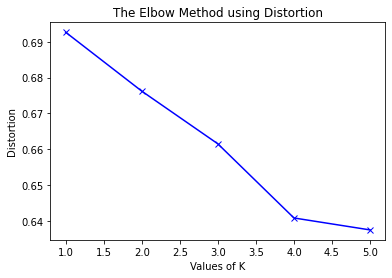

In [17]:
# Visualize the different value of Distortions
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()

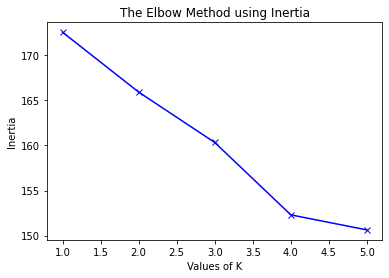

In [18]:
# Visualize the different value of Inertia
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax = plt.plot(K, inertias, 'bx-') 
ax = plt.xlabel('Values of K') 
ax = plt.ylabel('Inertia') 
ax = plt.title('The Elbow Method using Inertia') 
ax = plt.show()

In [ ]:
# Save folium map to html
report = dp.Report(dp.Plot(fig))
report.save(path='inertia_clustering.html', open=True)

In [ ]:
# Publish the Elbow Method Plot
dp.Report(dp.Plot(fig)).publish(name='Elbow_Method')

Based on our findings, I think it is safe to choose the value of clusters = 4.

**3. Build clustering model**

In [19]:
# Build clustering model
n_clusters = 4 # number of clusters

KMeansModel_bali = KMeans(n_clusters=n_clusters, random_state=4).fit(bali_clustering)
KMeansModel_bali.fit(bali_clustering)
cluster_labels = KMeansModel_bali.labels_

print(np.unique(cluster_labels))

[0 1 2 3]


Now let's add the result from the clustering model into the 'bali_clustering' dataframe, and merge it with 'bali_df' dataframe.

In [20]:
# Add clustering labels
subdist_venues_sorted.insert(0, 'Cluster Labels', cluster_labels)

# Collect 'bali_df' data and save it to bali_merged object
bali_merged = bali_df

# Merge 'bali_df' with 'subdist_venues_sorted'
bali_merged = bali_merged.join(subdist_venues_sorted.set_index('Sub-District'), on='Sub-District')

In [21]:
print(subdist_venues_sorted.shape)
print(bali_merged.shape)
bali_merged.head()

(315, 5)
(315, 11)


,Province,Regency/City,Sub-District,Geocoder,Location,Latitude,Longitude,Cluster Labels,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Bali,Kabupaten Buleleng,Banjar,"Banjar, Bali, Indonesia","Banjar, Bali, Indonesia",-8.205011,114.967194,1,Pool,Accessories Store,Outdoor Supply Store
1,Bali,Kabupaten Buleleng,Banyuatis,"Banyuatis, Bali, Indonesia","Banyuatis, Bali, Indonesia",-8.262936,115.031525,1,Salad Place,Accessories Store,Outdoors & Recreation
2,Bali,Kabupaten Buleleng,Dencarik,"Dencarik, Bali, Indonesia","Dencarik, Bali, Indonesia",-8.185746,114.982595,1,Indonesian Restaurant,Accessories Store,Outdoors & Recreation
3,Bali,Kabupaten Buleleng,Gesing,"Gesing, Bali, Indonesia","Gesing, Bali, 81152 BALI, Indonesia",-8.278434,115.054750,1,Tree,Accessories Store,Outdoors & Recreation
4,Bali,Kabupaten Buleleng,Kaliasem,"Kaliasem, Bali, Indonesia","Kaliasem, Bali, 00362, Indonesia",-8.170993,115.024820,1,Seafood Restaurant,Boat or Ferry,Restaurant


Then finally I can visualize the resulting clusters.

## Section 4 - Results & Examination

### Results

**1. Map of Bali with clusters**

I am going to create map of Bali with sub-districts superimposed on top.

In [22]:
# Create map of bali with sub-district superimposed on top
map_bali_clusters = folium.Map(location=[latitude_bali, longitude_bali], zoom_start=9.5)

# Set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
for lat, lon, dist, cluster in zip(bali_merged['Latitude'], bali_merged['Longitude'], bali_merged['Sub-District'], bali_merged['Cluster Labels']):
    label = folium.Popup(str(dist) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bali_clusters)
       
map_bali_clusters

In [ ]:
# Publish the Folium Map Bali Clusters
dp.Report(dp.Plot(map_bali_clusters)).publish(name='folium_map_bali_clusters')

The reason why the markers on the map do not resemble shape of clusters is because the clustering model was build based on frequency of occurences from venues of each sub-district, and not from coordinates (latitude, longitude) of each sub-district.

**Result 2 - Most common venues of each clusters**

**Cluster 0**

In [23]:
Urban_Suburb = bali_merged.loc[bali_merged['Cluster Labels'] == 0, bali_merged.columns[[2] + list(range(8, bali_merged.shape[1]))]].head(10)

In [24]:
Urban_Suburb

,Sub-District,1st Most common venue,2nd Most common venue,3rd Most common venue
31,Musi,Convenience Store,Asian Restaurant,Outdoor Supply Store
59,Sambirenteng,Balinese Restaurant,Convenience Store,Outlet Store
69,Tegal Kertha,Arcade,Food Truck,Convenience Store
71,Pedungan,Convenience Store,Chinese Restaurant,BBQ Joint
95,Tonja,Convenience Store,Indonesian Restaurant,Breakfast Spot
104,Sibang Gede,River,Accessories Store,Outdoors & Recreation
117,Dalung,Convenience Store,Accessories Store,Outlet Store
120,Tibubeneng,Convenience Store,Asian Restaurant,Sports Club
130,Sading,Convenience Store,Asian Restaurant,Accessories Store
146,Catur,Convenience Store,Accessories Store,Outlet Store


In [25]:
# Publish the Cluster 0 df
dp.Report(dp.DataTable(Urban_Suburb)).publish(name='cluster_0')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/cluster-0/


**Cluster 1**

In [26]:
Urban = bali_merged.loc[bali_merged['Cluster Labels'] == 1, bali_merged.columns[[2] + list(range(8, bali_merged.shape[1]))]].head(10)
Urban

,Sub-District,1st Most common venue,2nd Most common venue,3rd Most common venue
0,Banjar,Pool,Accessories Store,Outdoor Supply Store
1,Banyuatis,Salad Place,Accessories Store,Outdoors & Recreation
2,Dencarik,Indonesian Restaurant,Accessories Store,Outdoors & Recreation
3,Gesing,Tree,Accessories Store,Outdoors & Recreation
4,Kaliasem,Seafood Restaurant,Boat or Ferry,Restaurant
5,Temukus,Seafood Restaurant,Resort,Other Great Outdoors
7,Alasangker,Café,Accessories Store,Outdoors & Recreation
8,Astina,Field,Accessories Store,Mountain
9,Banjar Bali,Fast Food Restaurant,Indonesian Restaurant,Basketball Stadium
10,Banjar Jawa,Indonesian Restaurant,Dim Sum Restaurant,Coffee Shop


In [27]:
# Publish the Cluster 0 df
dp.Report(dp.DataTable(Urban)).publish(name='cluster_1')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/cluster-1/


**Cluster 2**

In [28]:
Recreation_Sites = bali_merged.loc[bali_merged['Cluster Labels'] == 2, bali_merged.columns[[2] + list(range(8, bali_merged.shape[1]))]].head(10)
Recreation_Sites

,Sub-District,1st Most common venue,2nd Most common venue,3rd Most common venue
47,Gunungsari,Mountain,Motorcycle Shop,Multiplex
140,Pengotan,Mountain,Motorcycle Shop,Multiplex
141,Banua,Mountain,Motorcycle Shop,Multiplex
145,Belanga,BBQ Joint,Mountain,Accessories Store
148,Mengani,Mountain,Motorcycle Shop,Multiplex
149,Satra,Mountain,Motorcycle Shop,Multiplex
152,Terunyan,Mountain,Shopping Mall,Outdoor Supply Store
154,Sulahan,Mountain,Motorcycle Shop,Multiplex
223,Bungaya (Bungaya Kauh),Mountain,Motorcycle Shop,Multiplex
225,Sibetan,Mountain,Motorcycle Shop,Multiplex


In [29]:
# Publish the Cluster 0 df
dp.Report(dp.DataTable(Recreation_Sites)).publish(name='cluster_2')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/cluster-2/


**Cluster 3**

In [30]:
Rural = bali_merged.loc[bali_merged['Cluster Labels'] == 3, bali_merged.columns[[2] + list(range(8, bali_merged.shape[1]))]].head(10)
Rural

,Sub-District,1st Most common venue,2nd Most common venue,3rd Most common venue
6,Tirtasari,Farm,Accessories Store,Mountain
22,Poh Bergong,Farm,Asian Restaurant,Accessories Store
48,Joanyar,Farm,Accessories Store,Mountain
58,Penuktukan,Farm,Asian Restaurant,Accessories Store
136,Bunutin,Farm,Accessories Store,Mountain
150,Sekaan,Farm,Garden,Accessories Store
153,Penglumbaran,Farm,Chinese Restaurant,Accessories Store
156,Bangbang,Farm,Coffee Shop,Accessories Store
224,Macang,Farm,Accessories Store,Mountain
243,Nongan,Farm,Café,Outdoors & Recreation


In [31]:
# Publish the Cluster 0 df
dp.Report(dp.DataTable(Rural)).publish(name='cluster_3')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/jonando93/reports/cluster-3/


Based on the results of each clusters, it appears that each clusters have their own types of venues.
<br><br>
**Cluster 0** is the *sub-urb areas* in Bali.
<br>
**Cluster 1** is mostly the *urban areas* in Bali. (With a few sub-districts as suburb.)
<br>
**Cluster 2** is the *recreational sites* in Bali.
<br>
**Cluster 3** is the *rural areas* in Bali.

In [ ]:
# Replacing Cluster Label values & replace index
bali_merged.reset_index(drop=True, inplace=True)
bali_merged['Cluster Labels'] = bali_merged['Cluster Labels'].replace([0, 1, 2, 3],['Suburb','Urban-Suburb','Recreational Site','Rural'])

In [ ]:
# Check the result
bali_merged.head()

## Section 5 - Discussion

**Comments on cluster 0 labeled as 'Suburb'.**
<br>
- Bali is a main tourist destination in Indonesia, it is common to see lots of venues even in *suburb* areas. 
<br>
- Distinguishable by the numbers of conventional stores that occurred as the most common venue at almost every sub-district, it is also a common thing in *suburb* and *rural* area to have alot of convenience store here in Indonesia, not just in Bali.
<br>
<br>

**Comments on cluster 1 labeled as 'Urban'.**
<br>
- The reason why many sub-districts labeled as *urban* compared to other cluster labels is because the amount of different types of venue categories.
<br>
- Based on my observation on the 'map_bali_clusters' result, cluster 1 is mostly consist of restaurants and some other types of venue categories. But there are also many *suburb* areas labeled as cluster 1 (e.g. Look at those 5 sub-district near 'Gilimanuk' on the top left of the map.) , that is because restaurants exist even in the *suburb* areas. 
<br>
<br>

**Comments on cluster 2 labeled as 'Recreational site'.** 
<br>
- Bali is a small island compared to other islands in Indonesia (e.g. Sumatra, Kalimantan, Sulawesi and Java) but it has many mountains perfect for recreational site with mountain views.
<br>
- "Beaches also can be labeled as recreational site!". True, but mostly, seashore areas in Bali are owned by hotels, villas, and restaurants. That is also the reason why seashores labeled as cluster 1 all over the map.
<br>
<br>

**Comments on cluster 3 labeled as 'Rural'.**
<br>
It can be seen by how many farm categorized as their most common venue by each sub-district in the cluster.
<br><br>

## Section 6 - Conclusion

Based on the results, it is safe to say that I can build a restaurant in **urban areas** in Bali. Bali is a small island and it is a main tourist destination in Indonesia. There are no "uncrowded" areas in Bali, every city/regency is **densely populated**.
<br><br>
But let us go back to the *Business Idea* of this project. The goal of this project is to find the most strategic location to build a restaurant, a location where there are alot of activities going on that makes it possible for the restaurant to gain some exposure and recognition. To answer that statement/idea, the best location to build a restaurant is in **Denpasar.**

Denpasar is the only city in Bali, others are regencies. It is obvious/easy to predict or assume that the answer to the Business Idea's question on where is the best location to gain some exposure or recognition would be **Denpasar.** But that is the beauty of Data Science. As Data Scientists, we gain insights from data and make our conclusion based on the result of our analysis, and sometimes, insights from data tell us something we already knew, but other times, it tells us something new and different than what we have already known.

**That concludes my Capstone Project - The Battle of Neighborhoods. Thank you! :D**